In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import pandas as pd
import numpy as np
from collections import Counter

import random


class EyeDiseaseDataset(Dataset):
    def __init__(self, tiff_dir=None, png_dir=None, csv_file=None, transform=None, balance_data=True):
        self.transform = transform
        self.image_paths = []
        self.labels = []

        
        keratitis_images = []
        epiphora_images = []
        normal_images = []

        # Load TIFF (Keratitis) images
        if tiff_dir and os.path.exists(tiff_dir):
            tiff_files = [f for f in os.listdir(tiff_dir) if f.lower().endswith('.tif')]
            keratitis_images = [(os.path.join(tiff_dir, f), 2) for f in tiff_files]  # Label 2 for keratitis

        # Load PNG images using CSV
        if csv_file and png_dir:
            data = pd.read_csv(csv_file).dropna()
            data.iloc[:, 0] = data.iloc[:, 0].astype(str)  # Ensure filenames are strings

            # Map labels to numerical values
            label_mapping = {"normal": 0, "mild": 1, "moderate": 1, "severe": 1}
            png_files = [(os.path.join(png_dir, f), label_mapping[l]) for f, l in zip(data.iloc[:, 0], data.iloc[:, 1]) if os.path.exists(os.path.join(png_dir, f))]

            # Separate images by class
            for path, label in png_files:
                if label == 0:
                    normal_images.append((path, label))
                elif label == 1:
                    epiphora_images.append((path, label))

        # Balance the dataset
        if balance_data:
            num_keratitis = len(keratitis_images)  # Number of keratitis images
            normal_images = random.sample(normal_images, min(num_keratitis, len(normal_images)))
            epiphora_images = random.sample(epiphora_images, min(num_keratitis, len(epiphora_images)))

        # Merge all selected images into final dataset
        self.image_paths, self.labels = zip(*(keratitis_images + epiphora_images + normal_images))

        # Print dataset distribution for verification
        print(f"Balanced Dataset - Normal: {len(normal_images)}, Epiphora: {len(epiphora_images)}, Keratitis: {len(keratitis_images)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset with balancing enabled
dataset = EyeDiseaseDataset(
    tiff_dir = r"C:\Users\Ludovic\Pytorch\ExpoSciences\Datasets\Blue_Light",
    png_dir = r"C:\Users\Ludovic\Pytorch\ExpoSciences\Datasets\26172919\train\train",
    csv_file = r"C:\Users\Ludovic\Pytorch\ExpoSciences\Datasets\26172919\SLID_E_information.csv",
    transform=transform,
    balance_data=True  # Enable dataset balancing
)




num_tiff = sum(1 for path in dataset.image_paths if path.endswith('.tif'))
num_png = sum(1 for path in dataset.image_paths if path.endswith('.png'))

print(f"Total images in dataset: {len(dataset)}")
print(f"TIFF images: {num_tiff}")
print(f"PNG images: {num_png}")

# Handle class imbalance
label_counts = Counter(dataset.labels)
class_weights = {label: 1.0 / count for label, count in label_counts.items()}
sample_weights = [class_weights[label] for label in dataset.labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Check if dataset is empty before splitting
if len(dataset) == 0:
    raise ValueError("Dataset is empty. Check file paths and data integrity.")

# Split dataset into train and validation sets
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Create DataLoaders, filtering out None values
def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None]
    return torch.utils.data.dataloader.default_collate(batch) if batch else None

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Model definition
class EyeDiseaseModel(nn.Module):
    def __init__(self, num_classes=3):  # Three classes: normal (0), epiphora (1), disease (2)
        super(EyeDiseaseModel, self).__init__()
        self.model = models.resnet34(pretrained=True)  

        for param in self.model.parameters():
            param.requires_grad = False  # Freeze base model weights

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Modify final layer

    def forward(self, x):
        return self.model(x)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EyeDiseaseModel(num_classes=3).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function
import torch
import os

# Model file path
MODEL_PATH = "newer_model.pth"

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2):
    # If a saved model exists, ask user for choice
    if os.path.exists(MODEL_PATH):
        choice = input("A saved model was found. Enter 'train' to retrain or 'load' to use the existing model: ").strip().lower()

        if choice == "load":
            print("Loading existing model instead of training.")
            model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
            model.eval()
            return
        elif choice != "train":
            print("Invalid input. Defaulting to loading model.")
            model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
            model.eval()
            return
    
    print("No saved model found or user chose to train. Starting training...")

    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for batch in train_loader:
            if batch is None: continue  # Skip empty batches
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        train_accuracy = 100 * correct_preds / total_preds
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Validation
        model.eval()
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for batch in val_loader:
                if batch is None: continue  # Skip empty batches
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_accuracy = 100 * correct_preds / total_preds
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

        # Save best model automatically
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"New best model saved with accuracy: {val_accuracy:.2f}%")

    print("Training Complete")

# Run training (if necessary)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

# Load the best model automatically after training
print("Loading the best saved model...")



Balanced Dataset - Normal: 133, Epiphora: 133, Keratitis: 133
Total images in dataset: 399
TIFF images: 133
PNG images: 0


c:\Users\Ludovic\anaconda3\envs\AnExpoProject\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ludovic\anaconda3\envs\AnExpoProject\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Ludovic/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100.0%


No saved model found or user chose to train. Starting training...
Epoch [1/50], Loss: 1.0933, Train Accuracy: 38.87%
Validation Accuracy: 50.00%
New best model saved with accuracy: 50.00%
Epoch [2/50], Loss: 1.0739, Train Accuracy: 40.44%
Validation Accuracy: 41.25%
Epoch [3/50], Loss: 1.0358, Train Accuracy: 43.89%
Validation Accuracy: 53.75%
New best model saved with accuracy: 53.75%
Epoch [4/50], Loss: 1.0076, Train Accuracy: 50.78%
Validation Accuracy: 56.25%
New best model saved with accuracy: 56.25%
Epoch [5/50], Loss: 0.9773, Train Accuracy: 52.98%
Validation Accuracy: 67.50%
New best model saved with accuracy: 67.50%
Epoch [6/50], Loss: 0.9576, Train Accuracy: 54.23%
Validation Accuracy: 61.25%
Epoch [7/50], Loss: 0.9590, Train Accuracy: 52.98%
Validation Accuracy: 58.75%
Epoch [8/50], Loss: 0.9134, Train Accuracy: 56.74%
Validation Accuracy: 61.25%
Epoch [9/50], Loss: 0.9064, Train Accuracy: 61.13%
Validation Accuracy: 70.00%
New best model saved with accuracy: 70.00%
Epoch [1

C:\Users\Ludovic\AppData\Local\Temp\ipykernel_21440\3225762362.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location

Accuracy on keratitis images: 66.17%


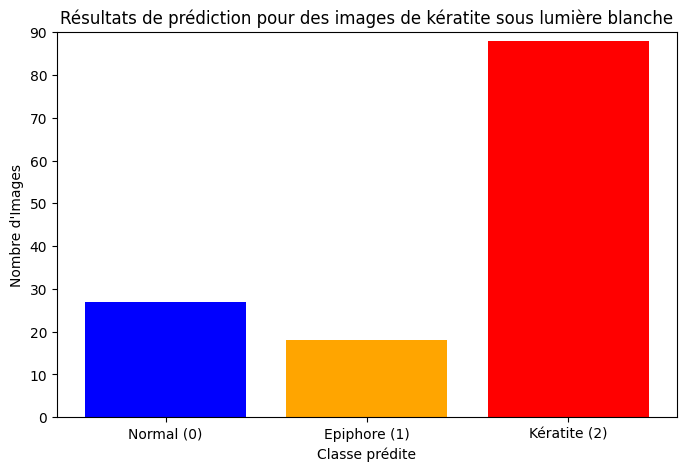

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from collections import Counter
from torchvision import models

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
class EyeDiseaseModel(nn.Module):
    def __init__(self, num_classes=3):
        super(EyeDiseaseModel, self).__init__()
        self.model = models.resnet34(pretrained=False)  # Set to False to avoid loading weights
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize model and load weights
MODEL_PATH = "newer_model.pth"
model = EyeDiseaseModel(num_classes=3).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# Define transformations (same as used in training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define folder containing keratitis images
image_folder = r"C:\Users\Ludovic\Pytorch\ExpoSciences\Datasets\White_Light"  # Change this to the actual folder
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('png', 'jpg', 'jpeg', 'tif'))]

# Predict and store results
correct = 0
total = 0
predictions = []

for img_path in image_paths:
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predictions.append(predicted.item())
        if predicted.item() == 2:  # Expected class for keratitis
            correct += 1
        total += 1

# Compute accuracy
accuracy = correct / total * 100
print(f"Accuracy on keratitis images: {accuracy:.2f}%")

# Plot results
class_counts = Counter(predictions)
labels = ["Normal (0)", "Epiphore (1)", "Kératite (2)"]
prediction_counts = [class_counts.get(i, 0) for i in range(3)]

plt.figure(figsize=(8, 5))
plt.bar(labels, prediction_counts, color=['blue', 'orange', 'red'])
plt.xlabel("Classe prédite")
plt.ylabel("Nombre d'Images")
plt.title("Résultats de prédiction pour des images de kératite sous lumière blanche")
plt.ylim(0, max(prediction_counts) + 2)
plt.show()


model.conv1.weight: True
model.bn1.weight: True
model.bn1.bias: True
model.layer1.0.conv1.weight: True
model.layer1.0.bn1.weight: True
model.layer1.0.bn1.bias: True
model.layer1.0.conv2.weight: True
model.layer1.0.bn2.weight: True
model.layer1.0.bn2.bias: True
model.layer1.1.conv1.weight: True
model.layer1.1.bn1.weight: True
model.layer1.1.bn1.bias: True
model.layer1.1.conv2.weight: True
model.layer1.1.bn2.weight: True
model.layer1.1.bn2.bias: True
model.layer1.2.conv1.weight: True
model.layer1.2.bn1.weight: True
model.layer1.2.bn1.bias: True
model.layer1.2.conv2.weight: True
model.layer1.2.bn2.weight: True
model.layer1.2.bn2.bias: True
model.layer2.0.conv1.weight: True
model.layer2.0.bn1.weight: True
model.layer2.0.bn1.bias: True
model.layer2.0.conv2.weight: True
model.layer2.0.bn2.weight: True
model.layer2.0.bn2.bias: True
model.layer2.0.downsample.0.weight: True
model.layer2.0.downsample.1.weight: True
model.layer2.0.downsample.1.bias: True
model.layer2.1.conv1.weight: True
model.la

c:\Users\Ludovic\anaconda3\envs\AnExpoProject\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


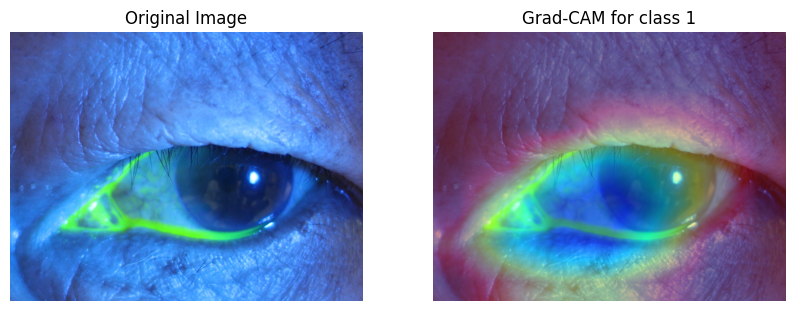

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Assuming you have a model defined as 'model'

# Unfreeze all layers (if needed)
for param in model.parameters():
    param.requires_grad = True


# Check if the layers are properly unfrozen
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

# 🔍 Find the last convolutional layer dynamically
def get_last_conv_layer(model):
    for name, module in reversed(list(model.named_modules())):  # Convert to list and reverse
        if isinstance(module, nn.Conv2d):
            return name, module
    raise ValueError("No convolutional layer found in model!")

# 🎨 Grad-CAM Implementation
def grad_cam(model, image_path):
    model.eval()
    
    # Get last conv layer dynamically
    layer_name, target_layer = get_last_conv_layer(model)
    print(f"Using last conv layer: {layer_name}")

    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)  # Store forward activations

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])  # Store gradients from backward pass

    # Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(next(model.parameters()).device)

    # Forward pass
    output = model(input_tensor)
    class_idx = torch.argmax(output).item()

    # Backward pass
    model.zero_grad()
    output[0, class_idx].backward()

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # Ensure gradients and activations were captured
    if not gradients or not activations:
        raise RuntimeError("Gradients or activations were not captured. Check if the model has frozen layers.")

    gradients = gradients[0]  # Extract from list
    activations = activations[0]  # Extract from list

    # Compute Grad-CAM heatmap
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize

    # Overlay heatmap on image
    heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img = np.array(image)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Show results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM for class {class_idx}")
    plt.axis("off")

    plt.show()

# 🏃 Run Grad-CAM
image_path = r"C:\Users\Ludovic\Pytorch\ExpoSciences\Datasets\26172919\train\test\test\c3506cae4220230501003S_01L.jpg"
grad_cam(model, image_path)


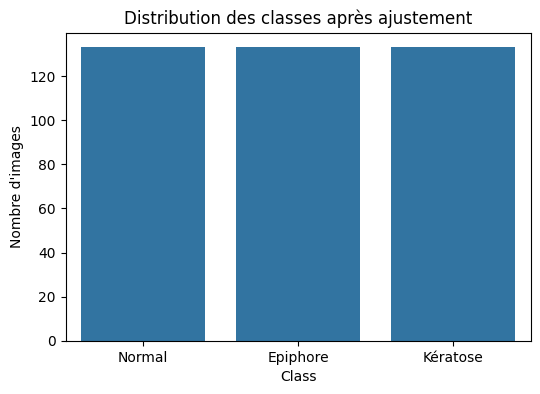

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of samples per class
label_counts = pd.Series(dataset.labels).value_counts()

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(ticks=[0, 1, 2], labels=["Normal", "Epiphore", "Kératose"])
plt.xlabel("Class")
plt.ylabel("Nombre d'images")
plt.title("Distribution des classes après ajustement")
plt.show()

In [38]:
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("Model loaded successfully!")

# Class labels mapping
class_names = {0: "normal", 1: "epiphora", 2: "keratitis"}

def predict(image_path):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    
    # Perform multiple augmented predictions
    predictions = []
    for _ in range(5):  # 5 augmented versions
        transformed_image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(transformed_image)
            _, predicted = torch.max(output, 1)
            predictions.append(predicted.item())

    final_prediction = max(set(predictions), key=predictions.count)  # Majority vote
    return class_names[final_prediction]

    

image_path = r"C:\Users\Ludovic\Pytorch\ExpoSciences\Datasets\26172919\train\test\test\4aa659356f20211020007S_06R.jpg"
predicted_label = predict(image_path)
print(f"Predicted Class: {predicted_label}")  

Model loaded successfully!
Predicted Class: normal


C:\Users\Ludovic\AppData\Local\Temp\ipykernel_18848\1132340223.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=

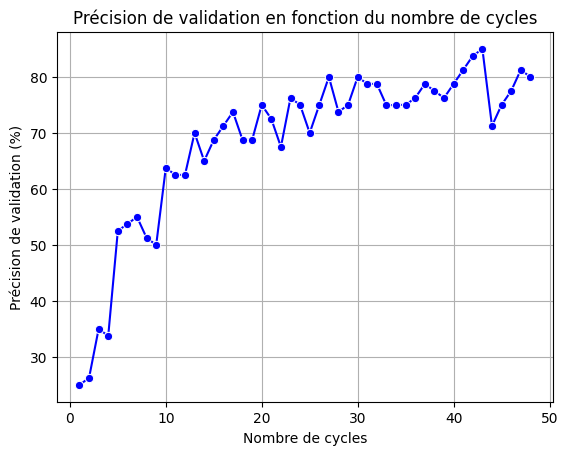

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data from training output (replace with your actual values)
epochs = list(range(1, 49))  # Epochs from 1 to 50
validation_accuracy = [
    25.00, 26.25, 35.00, 33.75, 52.50, 53.75, 55.00, 51.25, 50.00, 63.75,
    62.50, 62.50, 70.00, 65.00, 68.75, 71.25, 73.75, 68.75, 68.75, 75.00,
    72.50, 67.50, 76.25, 75.00, 70.00, 75.00, 80.00, 73.75, 75.00, 80.00,
    78.75, 78.75, 74.92, 75.00, 75.00, 76.25, 78.75, 77.50, 76.25, 78.75,
    81.25, 83.75, 85.00, 71.25, 75.00, 77.50, 81.25, 80.00
]

# Create a DataFrame
data = pd.DataFrame({'Nombre de cycles': epochs, 'Précision de validation': validation_accuracy})

# Plot using Seaborn
sns.lineplot(x='Nombre de cycles', y='Précision de validation', data=data, marker='o', color='b')

# Add labels and title
plt.xlabel('Nombre de cycles')
plt.ylabel('Précision de validation (%)')
plt.title('Précision de validation en fonction du nombre de cycles')

# Display grid and plot
plt.grid(True)
plt.show()


In [42]:
epochs = list(range(1, 49))  # 50 epochs
validation_accuracy = [
    25.00, 26.25, 35.00, 33.75, 52.50, 53.75, 55.00, 51.25, 50.00, 63.75,
    62.50, 62.50, 70.00, 65.00, 68.75, 71.25, 73.75, 68.75, 68.75, 75.00,
    72.50, 67.50, 76.25, 75.00, 70.00, 75.00, 80.00, 73.75, 75.00, 80.00,
    78.75, 78.75, 74.92, 75.00, 75.00, 76.25, 78.75, 77.50, 76.25, 78.75,
    81.25, 83.75, 85.00, 71.25, 75.00, 77.50, 81.25, 80.00  # Ensure 50 values here
]

# Check lengths
print(len(epochs))  # Should print 50
print(len(validation_accuracy))  # Should print 50


48
48


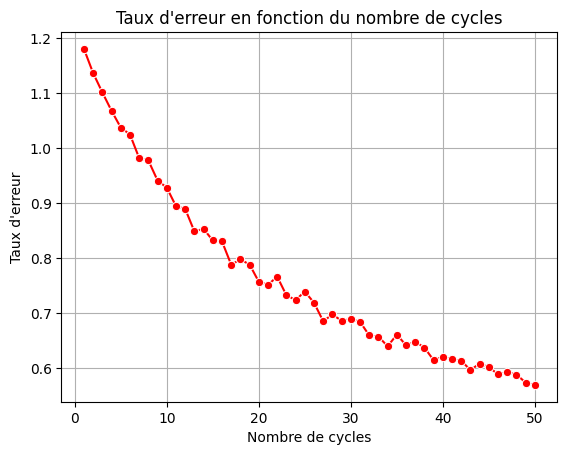

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data from training output (replace with your actual values)
epochs = list(range(1, 51))  # Epochs from 1 to 50
loss = [
    1.1798, 1.1359, 1.1009, 1.0675, 1.0371, 1.0245, 0.9818, 0.9774, 0.9410, 0.9281,
    0.8945, 0.8895, 0.8488, 0.8533, 0.8322, 0.8306, 0.7883, 0.7977, 0.7886, 0.7573,
    0.7518, 0.7666, 0.7328, 0.7242, 0.7394, 0.7193, 0.6857, 0.6979, 0.6865, 0.6895,
    0.6848, 0.6599, 0.6578, 0.6403, 0.6613, 0.6422, 0.6486, 0.6377, 0.6150, 0.6216,
    0.6168, 0.6140, 0.5971, 0.6089, 0.6023, 0.5895, 0.5934, 0.5889, 0.5743, 0.5701
]

# Create a DataFrame
data = pd.DataFrame({'Nombre de cycles': epochs, "Taux d'erreur": loss})

# Plot using Seaborn
sns.lineplot(x='Nombre de cycles', y="Taux d'erreur", data=data, marker='o', color='r')

# Add labels and title
plt.xlabel('Nombre de cycles')
plt.ylabel("Taux d'erreur")
plt.title("Taux d'erreur en fonction du nombre de cycles")

# Display grid and plot
plt.grid(True)
plt.show()


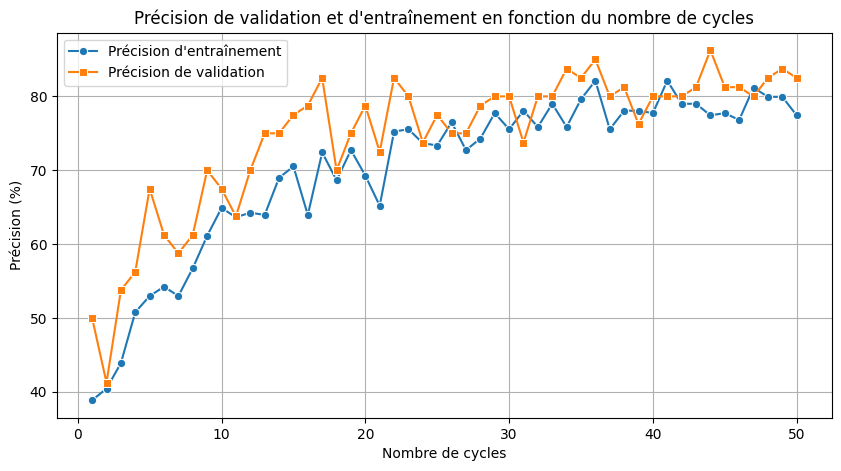

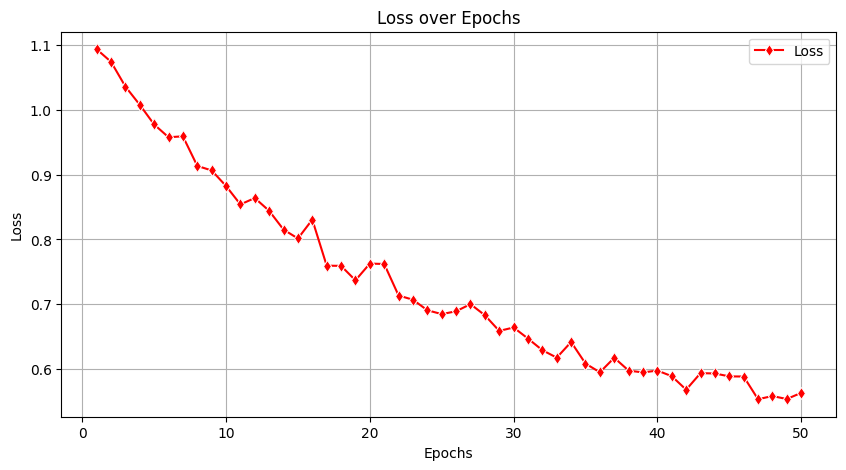

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data
epochs = np.arange(1, 51)
loss = [1.0933, 1.0739, 1.0358, 1.0076, 0.9773, 0.9576, 0.9590, 0.9134, 0.9064, 0.8824, 
        0.8540, 0.8639, 0.8441, 0.8152, 0.8015, 0.8306, 0.7596, 0.7593, 0.7370, 0.7628, 
        0.7622, 0.7136, 0.7071, 0.6909, 0.6849, 0.6893, 0.7003, 0.6832, 0.6590, 0.6643, 
        0.6472, 0.6293, 0.6178, 0.6419, 0.6087, 0.5952, 0.6176, 0.5978, 0.5950, 0.5979, 
        0.5892, 0.5684, 0.5939, 0.5934, 0.5889, 0.5887, 0.5537, 0.5586, 0.5540, 0.5635]
train_accuracy = [38.87, 40.44, 43.89, 50.78, 52.98, 54.23, 52.98, 56.74, 61.13, 64.89, 
                  63.64, 64.26, 63.95, 68.97, 70.53, 63.95, 72.41, 68.65, 72.73, 69.28, 
                  65.20, 75.24, 75.55, 73.67, 73.35, 76.49, 72.73, 74.29, 77.74, 75.55, 
                  78.06, 75.86, 79.00, 75.86, 79.62, 82.13, 75.55, 78.06, 78.06, 77.74, 
                  82.13, 79.00, 79.00, 77.43, 77.74, 76.80, 81.19, 79.94, 79.94, 77.43]
val_accuracy = [50.00, 41.25, 53.75, 56.25, 67.50, 61.25, 58.75, 61.25, 70.00, 67.50, 
                63.75, 70.00, 75.00, 75.00, 77.50, 78.75, 82.50, 70.00, 75.00, 78.75, 
                72.50, 82.50, 80.00, 73.75, 77.50, 75.00, 75.00, 78.75, 80.00, 80.00, 
                73.75, 80.00, 80.00, 83.75, 82.50, 85.00, 80.00, 81.25, 76.25, 80.00, 
                80.00, 80.00, 81.25, 86.25, 81.25, 81.25, 80.00, 82.50, 83.75, 82.50]

# Plot accuracy vs. epochs
plt.figure(figsize=(10, 5))
sns.lineplot(x=epochs, y=train_accuracy, label="Précision d'entraînement", marker='o')
sns.lineplot(x=epochs, y=val_accuracy, label='Précision de validation', marker='s')
plt.xlabel('Nombre de cycles')
plt.ylabel('Précision (%)')
plt.title("Précision de validation et d'entraînement en fonction du nombre de cycles")
plt.legend()
plt.grid()
plt.show()

# Plot loss vs. epochs
plt.figure(figsize=(10, 5))
sns.lineplot(x=epochs, y=loss, label='Loss', color='r', marker='d')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid()
plt.show()
